# 어텐션 모델

In [1]:
import os

# %cd /content/drive/MyDrive

os.getcwd()

'C:\\Users\\administrator'

# decoder_input : LSTM 수정 ver

# 1. 하이퍼 파라미터 설정

In [2]:
# 하이퍼 파라미터 설정
## 입력 패딩 파라미터
max_playlist_title_length = 25
max_songs = 10

## 2차원 입력 데이터, feature_length
lyric_length = 150
#audio_length = 7

## 임베딩 레이어 파라미터
### 임베딩 출력
embed_output_dim = 128
embed_outpu_dim = 128
### 임베딩 어휘 갯수
### 인코더-디코더
playlist_vocab = 119548
song_vocab = 261228      # 노래제목의 갯수

### 임베딩에 속한 어휘(토큰) 갯수
artist_vocab = 64384
album_vocab = 167466
genre_vocab = 79
release_date_vocab = 58
lyric_vocab = 119517

## LSTM units 파라미터
lstm_units = 128

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, TimeDistributed, Dropout
from tensorflow.keras.models import Model

# 2. 다중 출력 모델

In [8]:
# 입력 레이어 정의
playlist_title_input = Input(shape=(max_playlist_title_length,), name= 'encoder_input')

song_input = Input(shape=(max_songs,), name= 'song_input')
artist_input = Input(shape=(max_songs,), name= 'artist_input')
album_input = Input(shape=(max_songs,), name= 'album_input')
genre_input = Input(shape=(max_songs,), name= 'genre_input')
release_date_input = Input(shape=(max_songs,), name= 'release_date_input')
# 가사 데이터 입력 레이어 정의
# lyric_input = Input(shape=(max_songs, lyric_length), name= 'lyric_input')

# 임베딩 레이어 정의
playlist_title_embedding = Embedding(playlist_vocab, embed_output_dim, name= 'encoder_embedd')(playlist_title_input)
playlist_title_embedding = Dropout(0.2)(playlist_title_embedding)

song_embedding = Embedding(song_vocab, embed_output_dim, name= 'decoder_embedd')(song_input)
song_embedding = Dropout(0.2)(song_embedding)
artist_embedding = Embedding(artist_vocab, embed_output_dim)(artist_input)
artist_embedding = Dropout(0.2)(artist_embedding)
album_embedding = Embedding(album_vocab, embed_output_dim)(album_input)
album_embedding = Dropout(0.2)(album_embedding)
genre_embedding = Embedding(genre_vocab, embed_output_dim)(genre_input)
genre_embedding = Dropout(0.2)(genre_embedding)
release_date_embedding = Embedding(release_date_vocab, embed_output_dim)(release_date_input)
release_date_embedding = Dropout(0.2)(release_date_embedding)

# 가사 데이터 임베딩 레이어
# lyric_embedding = Embedding(lyric_vocab, embed_output_dim)
# time_distributed_lyric_embedding = TimeDistributed(lyric_embedding)(lyric_input)
# time_distributed_lyric_lstm = TimeDistributed(LSTM(lstm_units, return_sequences= False))(time_distributed_lyric_embedding)
# time_distributed_lyric_lstm = TimeDistributed(LSTM(lstm_units))(time_distributed_lyric_embedding)
# lyric_outputs = time_distributed_lyric_lstm(lyric_embedding)

# 인코더 LSTM
encoder_lstm = LSTM(lstm_units, return_state=True, 
                    dropout= 0.2, recurrent_dropout=0.2, name= 'encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(playlist_title_embedding)
encoder_states = [state_h, state_c]

# 디코더 LSTM
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, 
                    dropout=0.2, recurrent_dropout= 0.2, name= 'decoder_lstm')
## 연결 및 출력
decoder_song_outputs, _, _ = decoder_lstm(song_embedding, initial_state= encoder_states)
decoder_artist_outputs, _, _ = decoder_lstm(artist_embedding, initial_state= encoder_states)
decoder_album_outputs, _, _ = decoder_lstm(album_embedding, initial_state=encoder_states)
decoder_genre_outputs, _, _ = decoder_lstm(genre_embedding, initial_state=encoder_states)
decoder_release_date_outputs, _, _ = decoder_lstm(release_date_embedding, initial_state=encoder_states)
# decoder_lyric_outputs, _, _ = decoder_lstm(time_distributed_lyric_lstm, initial_state=encoder_states)

# 어텐션 메커니즘 적용
attention_layer = Attention(name='attention_layer')
song_attention = attention_layer([decoder_song_outputs, encoder_outputs])
artist_attention = attention_layer([decoder_artist_outputs, encoder_outputs])
album_attention = attention_layer([decoder_album_outputs, encoder_outputs])
genre_attention = attention_layer([decoder_genre_outputs, encoder_outputs])
release_date_attention = attention_layer([decoder_release_date_outputs, encoder_outputs])

# 최종 출력 레이어
final_song_output = Dense(song_vocab, activation='softmax', name= 'song_output')(song_attention)
final_artist_output = Dense(artist_vocab, activation='softmax', name= 'artist_output')(artist_attention)
final_album_output = Dense(album_vocab, activation='softmax', name= 'album_output')(album_attention)
final_genre_output = Dense(genre_vocab, activation='softmax', name= 'genre_output')(genre_attention)
final_release_date_output = Dense(release_date_vocab, activation='softmax', name= 'release_date_output')(release_date_attention)
# final_lyric_output = Dense(lyric_length, activation='relu')(decoder_lyric_outputs)

# 모델 정의
model = Model(inputs=[playlist_title_input, song_input, artist_input, album_input, 
                      genre_input, release_date_input],
              outputs=[final_song_output, final_artist_output, final_album_output, 
                       final_genre_output, final_release_date_output])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 25)]                 0         []                            
                                                                                                  
 song_input (InputLayer)     [(None, 10)]                 0         []                            
                                                                                                  
 encoder_embedd (Embedding)  (None, 25, 128)              1530214   ['encoder_input[0][0]']       
                                                          4                                       
                                                                                                  
 artist_input (InputLayer)   [(None, 10)]                 0         []                      

                                                                                                  
 release_date_output (Dense  (None, 10, 58)               7482      ['attention_layer[4][0]']     
 )                                                                                                
                                                                                                  
Total params: 142321567 (542.91 MB)
Trainable params: 142321567 (542.91 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


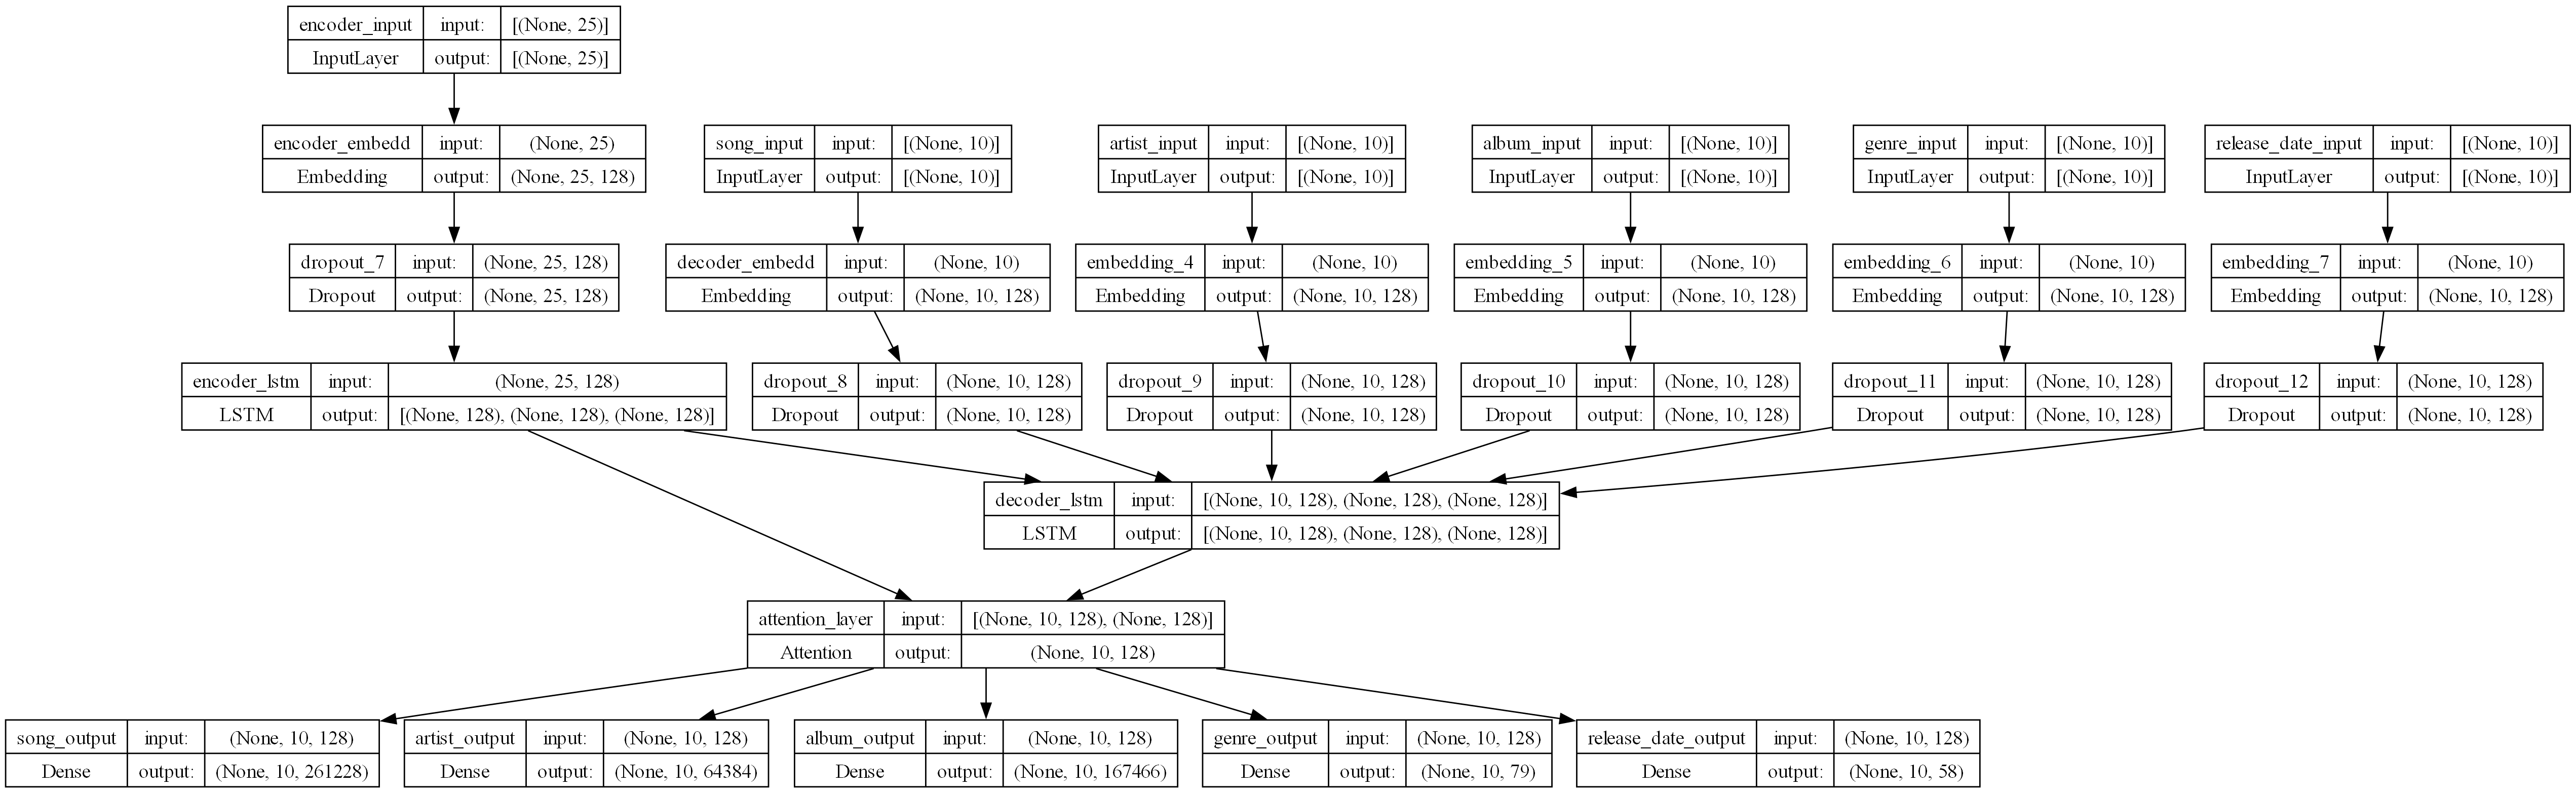

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, dpi= 200)

In [11]:
%cd C:\\Users\\administrator\\model_none_audio_ver0012\\

os.getcwd()

C:\Users\administrator\model_none_audio_ver0012


'C:\\Users\\administrator\\model_none_audio_ver0012'

In [12]:
# model.load_weights('multi_model_weights_epoch.h5')

# 훈련 데이터 생성

In [13]:
import numpy as np
#from tensorflow.keras.utils import to_categorical

# # 더미 데이터 생성
# num_samples = 10  # 샘플의 수

# # 입력 데이터
# playlist_titles = np.random.randint(0, playlist_vocab, size=(num_samples, max_playlist_title_length))
# songs = np.random.randint(0, song_vocab, size=(num_samples, max_songs))
# artists = np.random.randint(0, artist_vocab, size=(num_samples, max_songs))
# albums = np.random.randint(0, album_vocab, size=(num_samples, max_songs))
# genres = np.random.randint(0, genre_vocab, size=(num_samples, max_songs))
# release_dates = np.random.randint(0, release_date_vocab, size=(num_samples, max_songs))

# #lyrics = np.random.randint(0, lyric_vocab, size=(num_samples, max_songs, lyric_length))

# # 출력 데이터
# # 노래 제목과 가수 레이블은 (num_samples, max_songs) 형태
# song_labels = np.random.randint(0, song_vocab, size=(num_samples, max_songs))
# artist_labels = np.random.randint(0, artist_vocab, size=(num_samples, max_songs))
# album_labels = np.random.randint(0, album_vocab, size=(num_samples, max_songs))
# genre_labels = np.random.randint(0, genre_vocab, size=(num_samples, max_songs))
# release_date_labels = np.random.randint(0, release_date_vocab, size=(num_samples, max_songs))
# 가사 레이블 형태는 모델 출력층에 따라 결정
# 예시: (num_samples, max_songs, lyric_length) 형태
#lyric_labels = np.random.randint(0, lyric_vocab, size=(num_samples, max_songs, lyric_length))

In [14]:
%cd C:\\Users\\administrator\\전처리데이터\\
    
os.getcwd()

C:\Users\administrator\전처리데이터


'C:\\Users\\administrator\\전처리데이터'

In [15]:
# 입력 데이터 로드
playlist_titles = np.load('playlist_title_input_9.npy')

songs_input = np.load('song_inputs_9.npy')
artist_input = np.load('artist_input_9.npy')
album_input = np.load('album_input_9.npy')
genre_input = np.load('genre_input_9.npy')
release_date_input = np.load('release_date_input_9.npy')

# 타겟 데이터 로드
song_labels = np.load('song_targets_9.npy')
artist_labels = np.load('artist_targets_9.npy')
album_labels = np.load('album_targets_9.npy')
genre_labels = np.load('genre_targets_9.npy')
release_date_labels = np.load('release_date_targets_9.npy')

In [16]:
print(playlist_titles.shape)
print(songs_input.shape)
print(artist_input.shape)
print(album_input.shape)
print(genre_input.shape)
print(release_date_input.shape)

print(song_labels.shape)
print(artist_labels.shape)
print(album_labels.shape)
print(genre_labels.shape)
print(release_date_labels.shape)

(30000, 25)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 10)


# Train_Test 분리

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# 각 입력 및 출력 데이터에 대해 train_test_split 적용
train_playlist_titles, val_playlist_titles = train_test_split(playlist_titles, test_size=0.2, random_state=42)
train_songs, val_songs = train_test_split(songs_input, test_size=0.2, random_state=42)
train_artists, val_artists = train_test_split(artist_input, test_size=0.2, random_state=42)
train_albums, val_albums = train_test_split(album_input, test_size=0.2, random_state=42)
train_genres, val_genres = train_test_split(genre_input, test_size=0.2, random_state=42)
train_release_dates, val_release_dates = train_test_split(release_date_input, test_size=0.2, random_state=42)

train_song_labels, val_song_labels = train_test_split(song_labels, test_size=0.2, random_state=42)
train_artist_labels, val_artist_labels = train_test_split(artist_labels, test_size=0.2, random_state=42)
train_album_labels, val_album_labels = train_test_split(album_labels, test_size=0.2, random_state=42)
train_genre_labels, val_genre_labels = train_test_split(genre_labels, test_size=0.2, random_state=42)
train_release_date_labels, val_release_date_labels = train_test_split(release_date_labels, test_size=0.2, random_state=42)

In [19]:
# 훈련 및 검증 데이터셋 구성
X_train = {
    'encoder_input': train_playlist_titles,
    'song_input': train_songs,
    'artist_input': train_artists,
    'album_input': train_albums,
    'genre_input': train_genres,
    'release_date_input': train_release_dates
}

Y_train = {
    'song_output': train_song_labels,
    'artist_output': train_artist_labels,
    'album_output': train_album_labels,
    'genre_output': train_genre_labels,
    'release_date_output': train_release_date_labels
}

X_val = {
    'encoder_input': val_playlist_titles,
    'song_input': val_songs,
    'artist_input': val_artists,
    'album_input': val_albums,
    'genre_input': val_genres,
    'release_date_input': val_release_dates
}

Y_val = {
    'song_output': val_song_labels,
    'artist_output': val_artist_labels,
    'album_output': val_album_labels,
    'genre_output': val_genre_labels,
    'release_date_output': val_release_date_labels
}

In [20]:
%cd C:\\Users\\administrator\\model_none_audio_ver0012\\

os.getcwd()

C:\Users\administrator\model_none_audio_ver0012


'C:\\Users\\administrator\\model_none_audio_ver0012'

## 가중치 학습

In [ ]:
model.load_weights('best_model__.h5')

# 모델 컴파일 및 학습

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
# 체크포인트 콜백 설정
checkpoint_callback_5 = ModelCheckpoint(
    'best_model_5.h5', 
    monitor='song_output_accuracy',  # 훈련 데이터 정확도로 변경
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

checkpoint_callback_50 = ModelCheckpoint(
    'best_model_50.h5', 
    monitor='song_output_accuracy',  # 훈련 데이터 정확도로 변경
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

checkpoint_callback_100 = ModelCheckpoint(
    'best_model_100.h5', 
    monitor='song_output_accuracy',  # 훈련 데이터 정확도로 변경
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

checkpoint_callback_150 = ModelCheckpoint(
    'best_model_150.h5', 
    monitor='song_output_accuracy',  # 훈련 데이터 정확도로 변경
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

checkpoint_callback_200 = ModelCheckpoint(
    'best_model_200.h5', 
    monitor='song_output_accuracy',  # 훈련 데이터 정확도로 변경
    verbose=1, 
    save_best_only=True, 
    mode='max'
)
# # 조기 종료 콜백 설정
# early_stopping_callback = EarlyStopping(
#     monitor='val_loss', 
#     patience= 10, 
#     verbose= 1
# )

In [23]:
model.compile(optimizer='adam',
              loss={'song_output': 'sparse_categorical_crossentropy',
                    'artist_output': 'sparse_categorical_crossentropy',
                    'album_output': 'sparse_categorical_crossentropy',
                    'genre_output': 'sparse_categorical_crossentropy',
                    'release_date_output': 'sparse_categorical_crossentropy'},
              metrics={'song_output': ['accuracy']},
              # run_eagerly=True
             )

In [31]:
model.save_weights('multi_model_weights_5epoch.h5')

In [25]:
# 모델 학습
history_5 = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    epochs= 5,          # 적절한 에포크 수로 설정
    batch_size= 512,     # 적절한 배치 크기로 설정
    callbacks= [checkpoint_callback_5],
    verbose= 1
)

Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 31.8815 - song_output_loss: 9.4679 - artist_output_loss: 7.5291 - album_output_loss: 9.0366 - genre_output_loss: 2.8617 - release_date_output_loss: 2.9863 - song_output_accuracy: 0.1003
Epoch 1: val_song_output_accuracy did not improve from 0.10047
47/47 [==============================] - 235s 5s/step - loss: 31.8815 - song_output_loss: 9.4679 - artist_output_loss: 7.5291 - album_output_loss: 9.0366 - genre_output_loss: 2.8617 - release_date_output_loss: 2.9863 - song_output_accuracy: 0.1003 - val_loss: 32.9533 - val_song_output_loss: 9.9866 - val_artist_output_loss: 7.6831 - val_album_output_loss: 9.4456 - val_genre_output_loss: 2.8570 - val_release_date_output_loss: 2.9810 - val_song_output_accuracy: 0.1005
Epoch 2/5
47/47 [==============================] - ETA: 0s - loss: 31.5619 - song_output_loss: 9.3180 - artist_output_loss: 7.4783 - album_output_loss: 8.9225 - genre_output_loss: 2.8585 - release_date_output_loss:

## 50번 학습

In [28]:
# 모델 학습
history_50 = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    epochs= 50,          # 적절한 에포크 수로 설정
    batch_size= 512,     # 적절한 배치 크기로 설정
    callbacks= [checkpoint_callback_50],
    verbose= 1
)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 31.4410 - song_output_loss: 9.2636 - artist_output_loss: 7.4567 - album_output_loss: 8.8780 - genre_output_loss: 2.8584 - release_date_output_loss: 2.9843 - song_output_accuracy: 0.1004
Epoch 1: song_output_accuracy improved from -inf to 0.10036, saving model to best_model_50.h5
47/47 [==============================] - 244s 5s/step - loss: 31.4410 - song_output_loss: 9.2636 - artist_output_loss: 7.4567 - album_output_loss: 8.8780 - genre_output_loss: 2.8584 - release_date_output_loss: 2.9843 - song_output_accuracy: 0.1004 - val_loss: 33.5301 - val_song_output_loss: 10.2804 - val_artist_output_loss: 7.7504 - val_album_output_loss: 9.6571 - val_genre_output_loss: 2.8586 - val_release_date_output_loss: 2.9835 - val_song_output_accuracy: 0.1005
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 31.2994 - song_output_loss: 9.2125 - artist_output_loss: 7.4247 - album_output_loss: 8.8312 - genre_output_loss: 

47/47 [==============================] - ETA: 0s - loss: 27.5244 - song_output_loss: 8.5378 - artist_output_loss: 6.7102 - album_output_loss: 8.1570 - genre_output_loss: 1.9850 - release_date_output_loss: 2.1345 - song_output_accuracy: 0.1020
Epoch 11: song_output_accuracy did not improve from 0.10410
47/47 [==============================] - 236s 5s/step - loss: 27.5244 - song_output_loss: 8.5378 - artist_output_loss: 6.7102 - album_output_loss: 8.1570 - genre_output_loss: 1.9850 - release_date_output_loss: 2.1345 - song_output_accuracy: 0.1020 - val_loss: 30.1289 - val_song_output_loss: 9.8160 - val_artist_output_loss: 7.0818 - val_album_output_loss: 9.1345 - val_genre_output_loss: 1.9696 - val_release_date_output_loss: 2.1270 - val_song_output_accuracy: 0.1006
Epoch 12/50
47/47 [==============================] - ETA: 0s - loss: 27.4173 - song_output_loss: 8.5138 - artist_output_loss: 6.6844 - album_output_loss: 8.1339 - genre_output_loss: 1.9664 - release_date_output_loss: 2.1188 - s

47/47 [==============================] - ETA: 0s - loss: 26.7397 - song_output_loss: 8.3499 - artist_output_loss: 6.5224 - album_output_loss: 7.9671 - genre_output_loss: 1.8591 - release_date_output_loss: 2.0413 - song_output_accuracy: 0.1084
Epoch 21: song_output_accuracy improved from 0.10562 to 0.10836, saving model to best_model_50.h5
47/47 [==============================] - 241s 5s/step - loss: 26.7397 - song_output_loss: 8.3499 - artist_output_loss: 6.5224 - album_output_loss: 7.9671 - genre_output_loss: 1.8591 - release_date_output_loss: 2.0413 - song_output_accuracy: 0.1084 - val_loss: 30.3643 - val_song_output_loss: 10.1228 - val_artist_output_loss: 7.0338 - val_album_output_loss: 9.3120 - val_genre_output_loss: 1.8525 - val_release_date_output_loss: 2.0432 - val_song_output_accuracy: 0.1172
Epoch 22/50
47/47 [==============================] - ETA: 0s - loss: 26.6673 - song_output_loss: 8.3327 - artist_output_loss: 6.5072 - album_output_loss: 7.9489 - genre_output_loss: 1.8468

47/47 [==============================] - 242s 5s/step - loss: 26.1319 - song_output_loss: 8.1797 - artist_output_loss: 6.3970 - album_output_loss: 7.8025 - genre_output_loss: 1.7732 - release_date_output_loss: 1.9793 - song_output_accuracy: 0.1166 - val_loss: 30.5255 - val_song_output_loss: 10.2958 - val_artist_output_loss: 7.0255 - val_album_output_loss: 9.4244 - val_genre_output_loss: 1.7860 - val_release_date_output_loss: 1.9938 - val_song_output_accuracy: 0.1194
Epoch 32/50
47/47 [==============================] - ETA: 0s - loss: 26.1854 - song_output_loss: 8.1773 - artist_output_loss: 6.4047 - album_output_loss: 7.8028 - genre_output_loss: 1.7991 - release_date_output_loss: 2.0015 - song_output_accuracy: 0.1305
Epoch 32: song_output_accuracy improved from 0.11664 to 0.13046, saving model to best_model_50.h5
47/47 [==============================] - 242s 5s/step - loss: 26.1854 - song_output_loss: 8.1773 - artist_output_loss: 6.4047 - album_output_loss: 7.8028 - genre_output_loss: 1

Epoch 42/50
47/47 [==============================] - ETA: 0s - loss: 25.2008 - song_output_loss: 7.8931 - artist_output_loss: 6.1593 - album_output_loss: 7.5265 - genre_output_loss: 1.6782 - release_date_output_loss: 1.9438 - song_output_accuracy: 0.2014
Epoch 42: song_output_accuracy improved from 0.20131 to 0.20135, saving model to best_model_50.h5
47/47 [==============================] - 244s 5s/step - loss: 25.2008 - song_output_loss: 7.8931 - artist_output_loss: 6.1593 - album_output_loss: 7.5265 - genre_output_loss: 1.6782 - release_date_output_loss: 1.9438 - song_output_accuracy: 0.2014 - val_loss: 30.2528 - val_song_output_loss: 10.3318 - val_artist_output_loss: 6.8891 - val_album_output_loss: 9.4089 - val_genre_output_loss: 1.6758 - val_release_date_output_loss: 1.9472 - val_song_output_accuracy: 0.2010
Epoch 43/50
47/47 [==============================] - ETA: 0s - loss: 25.1412 - song_output_loss: 7.8778 - artist_output_loss: 6.1480 - album_output_loss: 7.5105 - genre_output_

In [29]:
model.save_weights('multi_model_weights_50epoch.h5')

## 100번 학습

In [30]:
history_100 = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    epochs= 50,          # 적절한 에포크 수로 설정
    batch_size= 512,     # 적절한 배치 크기로 설정
    callbacks= [checkpoint_callback_100],
    verbose= 1
)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 24.8359 - song_output_loss: 7.7825 - artist_output_loss: 6.0832 - album_output_loss: 7.4183 - genre_output_loss: 1.6271 - release_date_output_loss: 1.9249 - song_output_accuracy: 0.2015
Epoch 1: song_output_accuracy improved from -inf to 0.20152, saving model to best_model_100.h5
47/47 [==============================] - 243s 5s/step - loss: 24.8359 - song_output_loss: 7.7825 - artist_output_loss: 6.0832 - album_output_loss: 7.4183 - genre_output_loss: 1.6271 - release_date_output_loss: 1.9249 - song_output_accuracy: 0.2015 - val_loss: 30.3605 - val_song_output_loss: 10.4321 - val_artist_output_loss: 6.8876 - val_album_output_loss: 9.4783 - val_genre_output_loss: 1.6315 - val_release_date_output_loss: 1.9310 - val_song_output_accuracy: 0.2010
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 24.7978 - song_output_loss: 7.7703 - artist_output_loss: 6.0743 - album_output_loss: 7.4061 - genre_output_loss:

47/47 [==============================] - ETA: 0s - loss: 24.4918 - song_output_loss: 7.6691 - artist_output_loss: 6.0040 - album_output_loss: 7.3100 - genre_output_loss: 1.5969 - release_date_output_loss: 1.9119 - song_output_accuracy: 0.2018
Epoch 11: song_output_accuracy improved from 0.20173 to 0.20180, saving model to best_model_100.h5
47/47 [==============================] - 242s 5s/step - loss: 24.4918 - song_output_loss: 7.6691 - artist_output_loss: 6.0040 - album_output_loss: 7.3100 - genre_output_loss: 1.5969 - release_date_output_loss: 1.9119 - song_output_accuracy: 0.2018 - val_loss: 30.5419 - val_song_output_loss: 10.5483 - val_artist_output_loss: 6.8998 - val_album_output_loss: 9.5695 - val_genre_output_loss: 1.6068 - val_release_date_output_loss: 1.9175 - val_song_output_accuracy: 0.1938
Epoch 12/50
47/47 [==============================] - ETA: 0s - loss: 24.5339 - song_output_loss: 7.6725 - artist_output_loss: 6.0114 - album_output_loss: 7.3149 - genre_output_loss: 1.611

47/47 [==============================] - ETA: 0s - loss: 24.1715 - song_output_loss: 7.5606 - artist_output_loss: 5.9239 - album_output_loss: 7.2069 - genre_output_loss: 1.5777 - release_date_output_loss: 1.9024 - song_output_accuracy: 0.2019
Epoch 21: song_output_accuracy did not improve from 0.20192
47/47 [==============================] - 236s 5s/step - loss: 24.1715 - song_output_loss: 7.5606 - artist_output_loss: 5.9239 - album_output_loss: 7.2069 - genre_output_loss: 1.5777 - release_date_output_loss: 1.9024 - song_output_accuracy: 0.2019 - val_loss: 30.7184 - val_song_output_loss: 10.6623 - val_artist_output_loss: 6.9037 - val_album_output_loss: 9.6610 - val_genre_output_loss: 1.5862 - val_release_date_output_loss: 1.9052 - val_song_output_accuracy: 0.1998
Epoch 22/50
47/47 [==============================] - ETA: 0s - loss: 24.1385 - song_output_loss: 7.5503 - artist_output_loss: 5.9152 - album_output_loss: 7.1972 - genre_output_loss: 1.5753 - release_date_output_loss: 1.9005 - 

47/47 [==============================] - 235s 5s/step - loss: 23.8905 - song_output_loss: 7.4667 - artist_output_loss: 5.8494 - album_output_loss: 7.1179 - genre_output_loss: 1.5609 - release_date_output_loss: 1.8956 - song_output_accuracy: 0.2020 - val_loss: 30.9278 - val_song_output_loss: 10.7803 - val_artist_output_loss: 6.9213 - val_album_output_loss: 9.7611 - val_genre_output_loss: 1.5698 - val_release_date_output_loss: 1.8953 - val_song_output_accuracy: 0.1986
Epoch 32/50
47/47 [==============================] - ETA: 0s - loss: 23.8604 - song_output_loss: 7.4577 - artist_output_loss: 5.8411 - album_output_loss: 7.1096 - genre_output_loss: 1.5583 - release_date_output_loss: 1.8937 - song_output_accuracy: 0.2020
Epoch 32: song_output_accuracy did not improve from 0.20205
47/47 [==============================] - 235s 5s/step - loss: 23.8604 - song_output_loss: 7.4577 - artist_output_loss: 5.8411 - album_output_loss: 7.1096 - genre_output_loss: 1.5583 - release_date_output_loss: 1.89

Epoch 42/50
47/47 [==============================] - ETA: 0s - loss: 23.6077 - song_output_loss: 7.3633 - artist_output_loss: 5.7705 - album_output_loss: 7.0229 - genre_output_loss: 1.5568 - release_date_output_loss: 1.8943 - song_output_accuracy: 0.2001
Epoch 42: song_output_accuracy did not improve from 0.20239
47/47 [==============================] - 237s 5s/step - loss: 23.6077 - song_output_loss: 7.3633 - artist_output_loss: 5.7705 - album_output_loss: 7.0229 - genre_output_loss: 1.5568 - release_date_output_loss: 1.8943 - song_output_accuracy: 0.2001 - val_loss: 31.1833 - val_song_output_loss: 10.9168 - val_artist_output_loss: 6.9454 - val_album_output_loss: 9.8781 - val_genre_output_loss: 1.5523 - val_release_date_output_loss: 1.8907 - val_song_output_accuracy: 0.2013
Epoch 43/50
47/47 [==============================] - ETA: 0s - loss: 23.5577 - song_output_loss: 7.3508 - artist_output_loss: 5.7583 - album_output_loss: 7.0093 - genre_output_loss: 1.5479 - release_date_output_los

In [31]:
model.save_weights('multi_model_weights_100epoch.h5')

## 150번 학습

In [32]:
history_150 = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    epochs= 50,          # 적절한 에포크 수로 설정
    batch_size= 512,     # 적절한 배치 크기로 설정
    callbacks= [checkpoint_callback_150],
    verbose= 1
)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 23.2838 - song_output_loss: 7.2534 - artist_output_loss: 5.6910 - album_output_loss: 6.9217 - genre_output_loss: 1.5332 - release_date_output_loss: 1.8845 - song_output_accuracy: 0.2025
Epoch 1: song_output_accuracy improved from -inf to 0.20251, saving model to best_model_150.h5
47/47 [==============================] - 243s 5s/step - loss: 23.2838 - song_output_loss: 7.2534 - artist_output_loss: 5.6910 - album_output_loss: 6.9217 - genre_output_loss: 1.5332 - release_date_output_loss: 1.8845 - song_output_accuracy: 0.2025 - val_loss: 31.3369 - val_song_output_loss: 11.0020 - val_artist_output_loss: 6.9554 - val_album_output_loss: 9.9510 - val_genre_output_loss: 1.5416 - val_release_date_output_loss: 1.8868 - val_song_output_accuracy: 0.2012
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 23.2786 - song_output_loss: 7.2459 - artist_output_loss: 5.6860 - album_output_loss: 6.9163 - genre_output_loss:

47/47 [==============================] - ETA: 0s - loss: 23.0067 - song_output_loss: 7.1475 - artist_output_loss: 5.6184 - album_output_loss: 6.8302 - genre_output_loss: 1.5279 - release_date_output_loss: 1.8827 - song_output_accuracy: 0.2027
Epoch 11: song_output_accuracy did not improve from 0.20277
47/47 [==============================] - 236s 5s/step - loss: 23.0067 - song_output_loss: 7.1475 - artist_output_loss: 5.6184 - album_output_loss: 6.8302 - genre_output_loss: 1.5279 - release_date_output_loss: 1.8827 - song_output_accuracy: 0.2027 - val_loss: 31.6376 - val_song_output_loss: 11.1436 - val_artist_output_loss: 6.9921 - val_album_output_loss: 10.0839 - val_genre_output_loss: 1.5339 - val_release_date_output_loss: 1.8842 - val_song_output_accuracy: 0.2014
Epoch 12/50
47/47 [==============================] - ETA: 0s - loss: 22.9702 - song_output_loss: 7.1370 - artist_output_loss: 5.6089 - album_output_loss: 6.8203 - genre_output_loss: 1.5227 - release_date_output_loss: 1.8813 -

47/47 [==============================] - ETA: 0s - loss: 22.7824 - song_output_loss: 7.0595 - artist_output_loss: 5.5594 - album_output_loss: 6.7544 - genre_output_loss: 1.5275 - release_date_output_loss: 1.8816 - song_output_accuracy: 0.2030
Epoch 21: song_output_accuracy did not improve from 0.20306
47/47 [==============================] - 236s 5s/step - loss: 22.7824 - song_output_loss: 7.0595 - artist_output_loss: 5.5594 - album_output_loss: 6.7544 - genre_output_loss: 1.5275 - release_date_output_loss: 1.8816 - song_output_accuracy: 0.2030 - val_loss: 31.8107 - val_song_output_loss: 11.2380 - val_artist_output_loss: 7.0018 - val_album_output_loss: 10.1667 - val_genre_output_loss: 1.5248 - val_release_date_output_loss: 1.8794 - val_song_output_accuracy: 0.2013
Epoch 22/50
47/47 [==============================] - ETA: 0s - loss: 22.7248 - song_output_loss: 7.0430 - artist_output_loss: 5.5451 - album_output_loss: 6.7399 - genre_output_loss: 1.5183 - release_date_output_loss: 1.8786 -

47/47 [==============================] - ETA: 0s - loss: 22.4941 - song_output_loss: 6.9538 - artist_output_loss: 5.4852 - album_output_loss: 6.6653 - genre_output_loss: 1.5135 - release_date_output_loss: 1.8764 - song_output_accuracy: 0.2034
Epoch 31: song_output_accuracy did not improve from 0.20345
47/47 [==============================] - 236s 5s/step - loss: 22.4941 - song_output_loss: 6.9538 - artist_output_loss: 5.4852 - album_output_loss: 6.6653 - genre_output_loss: 1.5135 - release_date_output_loss: 1.8764 - song_output_accuracy: 0.2034 - val_loss: 32.1330 - val_song_output_loss: 11.3892 - val_artist_output_loss: 7.0351 - val_album_output_loss: 10.3091 - val_genre_output_loss: 1.5234 - val_release_date_output_loss: 1.8761 - val_song_output_accuracy: 0.2014
Epoch 32/50
47/47 [==============================] - ETA: 0s - loss: 22.4565 - song_output_loss: 6.9423 - artist_output_loss: 5.4752 - album_output_loss: 6.6547 - genre_output_loss: 1.5113 - release_date_output_loss: 1.8730 -

47/47 [==============================] - ETA: 0s - loss: 22.2307 - song_output_loss: 6.8494 - artist_output_loss: 5.4235 - album_output_loss: 6.5744 - genre_output_loss: 1.5113 - release_date_output_loss: 1.8722 - song_output_accuracy: 0.2037
Epoch 41: song_output_accuracy did not improve from 0.20369
47/47 [==============================] - 235s 5s/step - loss: 22.2307 - song_output_loss: 6.8494 - artist_output_loss: 5.4235 - album_output_loss: 6.5744 - genre_output_loss: 1.5113 - release_date_output_loss: 1.8722 - song_output_accuracy: 0.2037 - val_loss: 32.3835 - val_song_output_loss: 11.5050 - val_artist_output_loss: 7.0676 - val_album_output_loss: 10.4246 - val_genre_output_loss: 1.5155 - val_release_date_output_loss: 1.8709 - val_song_output_accuracy: 0.2012
Epoch 42/50
47/47 [==============================] - ETA: 0s - loss: 22.1810 - song_output_loss: 6.8332 - artist_output_loss: 5.4115 - album_output_loss: 6.5606 - genre_output_loss: 1.5057 - release_date_output_loss: 1.8700 -

In [33]:
model.save_weights('multi_model_weights_150epoch.h5')

## 200번 학습

In [34]:
history_200 = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    epochs= 50,          # 적절한 에포크 수로 설정
    batch_size= 512,     # 적절한 배치 크기로 설정
    callbacks= [checkpoint_callback_150],
    verbose= 1
)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 21.9337 - song_output_loss: 6.7405 - artist_output_loss: 5.3511 - album_output_loss: 6.4788 - genre_output_loss: 1.4980 - release_date_output_loss: 1.8652 - song_output_accuracy: 0.2042
Epoch 1: song_output_accuracy improved from 0.20419 to 0.20420, saving model to best_model_150.h5
47/47 [==============================] - 241s 5s/step - loss: 21.9337 - song_output_loss: 6.7405 - artist_output_loss: 5.3511 - album_output_loss: 6.4788 - genre_output_loss: 1.4980 - release_date_output_loss: 1.8652 - song_output_accuracy: 0.2042 - val_loss: 32.6870 - val_song_output_loss: 11.6437 - val_artist_output_loss: 7.1096 - val_album_output_loss: 10.5480 - val_genre_output_loss: 1.5145 - val_release_date_output_loss: 1.8711 - val_song_output_accuracy: 0.2012
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 21.9462 - song_output_loss: 6.7384 - artist_output_loss: 5.3544 - album_output_loss: 6.4793 - genre_output_l

47/47 [==============================] - ETA: 0s - loss: 21.7405 - song_output_loss: 6.6609 - artist_output_loss: 5.3077 - album_output_loss: 6.4086 - genre_output_loss: 1.4983 - release_date_output_loss: 1.8649 - song_output_accuracy: 0.2048
Epoch 11: song_output_accuracy improved from 0.20455 to 0.20482, saving model to best_model_150.h5
47/47 [==============================] - 242s 5s/step - loss: 21.7405 - song_output_loss: 6.6609 - artist_output_loss: 5.3077 - album_output_loss: 6.4086 - genre_output_loss: 1.4983 - release_date_output_loss: 1.8649 - song_output_accuracy: 0.2048 - val_loss: 32.8456 - val_song_output_loss: 11.7255 - val_artist_output_loss: 7.1203 - val_album_output_loss: 10.6209 - val_genre_output_loss: 1.5116 - val_release_date_output_loss: 1.8674 - val_song_output_accuracy: 0.2013
Epoch 12/50
47/47 [==============================] - ETA: 0s - loss: 21.7254 - song_output_loss: 6.6545 - artist_output_loss: 5.3031 - album_output_loss: 6.4026 - genre_output_loss: 1.49

47/47 [==============================] - ETA: 0s - loss: 21.5262 - song_output_loss: 6.5837 - artist_output_loss: 5.2542 - album_output_loss: 6.3373 - genre_output_loss: 1.4905 - release_date_output_loss: 1.8604 - song_output_accuracy: 0.2051
Epoch 21: song_output_accuracy improved from 0.20507 to 0.20508, saving model to best_model_150.h5
47/47 [==============================] - 244s 5s/step - loss: 21.5262 - song_output_loss: 6.5837 - artist_output_loss: 5.2542 - album_output_loss: 6.3373 - genre_output_loss: 1.4905 - release_date_output_loss: 1.8604 - song_output_accuracy: 0.2051 - val_loss: 33.2180 - val_song_output_loss: 11.8961 - val_artist_output_loss: 7.1735 - val_album_output_loss: 10.7801 - val_genre_output_loss: 1.5046 - val_release_date_output_loss: 1.8637 - val_song_output_accuracy: 0.2013
Epoch 22/50
47/47 [==============================] - ETA: 0s - loss: 21.5559 - song_output_loss: 6.5904 - artist_output_loss: 5.2627 - album_output_loss: 6.3448 - genre_output_loss: 1.49

47/47 [==============================] - ETA: 0s - loss: 21.3642 - song_output_loss: 6.5179 - artist_output_loss: 5.2164 - album_output_loss: 6.2760 - genre_output_loss: 1.4937 - release_date_output_loss: 1.8601 - song_output_accuracy: 0.2056
Epoch 31: song_output_accuracy did not improve from 0.20559
47/47 [==============================] - 237s 5s/step - loss: 21.3642 - song_output_loss: 6.5179 - artist_output_loss: 5.2164 - album_output_loss: 6.2760 - genre_output_loss: 1.4937 - release_date_output_loss: 1.8601 - song_output_accuracy: 0.2056 - val_loss: 33.3024 - val_song_output_loss: 11.9397 - val_artist_output_loss: 7.1748 - val_album_output_loss: 10.8173 - val_genre_output_loss: 1.5076 - val_release_date_output_loss: 1.8630 - val_song_output_accuracy: 0.2014
Epoch 32/50
47/47 [==============================] - ETA: 0s - loss: 21.3535 - song_output_loss: 6.5141 - artist_output_loss: 5.2160 - album_output_loss: 6.2726 - genre_output_loss: 1.4904 - release_date_output_loss: 1.8602 -

47/47 [==============================] - ETA: 0s - loss: 21.2231 - song_output_loss: 6.4608 - artist_output_loss: 5.1855 - album_output_loss: 6.2243 - genre_output_loss: 1.4922 - release_date_output_loss: 1.8603 - song_output_accuracy: 0.2062
Epoch 41: song_output_accuracy did not improve from 0.20620
47/47 [==============================] - 237s 5s/step - loss: 21.2231 - song_output_loss: 6.4608 - artist_output_loss: 5.1855 - album_output_loss: 6.2243 - genre_output_loss: 1.4922 - release_date_output_loss: 1.8603 - song_output_accuracy: 0.2062 - val_loss: 33.6465 - val_song_output_loss: 12.0878 - val_artist_output_loss: 7.2485 - val_album_output_loss: 10.9476 - val_genre_output_loss: 1.5012 - val_release_date_output_loss: 1.8615 - val_song_output_accuracy: 0.2014
Epoch 42/50
47/47 [==============================] - ETA: 0s - loss: 21.1858 - song_output_loss: 6.4500 - artist_output_loss: 5.1761 - album_output_loss: 6.2142 - genre_output_loss: 1.4877 - release_date_output_loss: 1.8577 -

In [35]:
model.save_weights('multi_model_weights_200epoch.h5')

In [36]:
## 250번

In [37]:
checkpoint_callback_250 = ModelCheckpoint(
    'best_model_250.h5', 
    monitor='song_output_accuracy',  # 훈련 데이터 정확도로 변경
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

In [38]:
model.save_weights('multi_model_weights_250epoch.h5')

# Acc and Val_Acc 비교

In [40]:
import matplotlib.pyplot as plt

In [28]:
history_5.history

{'loss': [33.95880126953125,
  31.49260711669922,
  29.555086135864258,
  28.977304458618164,
  28.374948501586914],
 'song_output_loss': [10.277338981628418,
  9.425273895263672,
  9.03617000579834,
  8.909564018249512,
  8.799932479858398],
 'artist_output_loss': [7.998125076293945,
  7.446320533752441,
  7.055593967437744,
  6.9444661140441895,
  6.814121246337891],
 'album_output_loss': [9.71289348602295,
  8.98388671875,
  8.595954895019531,
  8.474105834960938,
  8.359829902648926],
 'genre_output_loss': [2.9282333850860596,
  2.7564353942871094,
  2.3732998371124268,
  2.2629334926605225,
  2.129042625427246],
 'release_date_output_loss': [3.042210340499878,
  2.8807010650634766,
  2.494063377380371,
  2.386218309402466,
  2.2720301151275635],
 'song_output_accuracy': [0.0996749997138977,
  0.10179027915000916,
  0.1091972216963768,
  0.18816527724266052,
  0.20042777061462402],
 'val_loss': [32.610633850097656,
  30.304962158203125,
  30.299482345581055,
  29.68724250793457,
  

In [56]:
# 실제 에포크 수
actual_epochs = len(history_200.history['song_output_accuracy'])

# 그래프에 표시할 x축 눈금 생성 (150부터 시작)
xticks = range(150, 150 + actual_epochs)

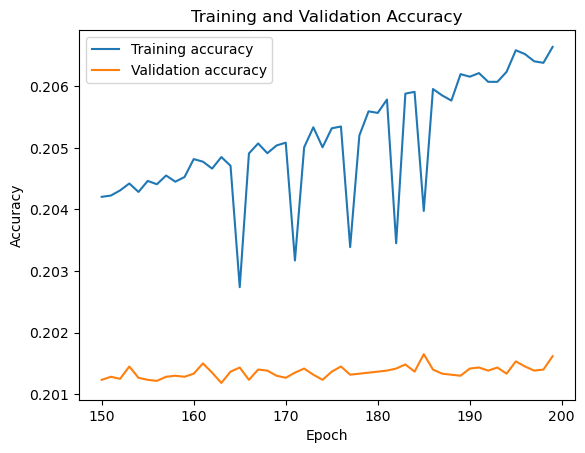

In [57]:
plt.plot(xticks, history_200.history['song_output_accuracy'], label='Training accuracy')
plt.plot(xticks, history_200.history['val_song_output_accuracy'], label='Validation accuracy')  # val_accuracy를 확인
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 인퍼런스 모델 작성

## Encoder

In [66]:
# 인코더 모델 정의 (LSTM 레이어 이름 일치)
encoder_lstm = LSTM(lstm_units, return_state=True, return_sequences=True, name='encoder_lstm')(playlist_title_embedding)
encoder_outputs, state_h, state_c = encoder_lstm
encoder_model = Model(playlist_title_input, [encoder_outputs, state_h, state_c])

# 인코더 모델 요약
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 25)]              0         
                                                                 
 encoder_embedd (Embedding)  (None, 25, 128)           15302144  
                                                                 
 dropout_7 (Dropout)         (None, 25, 128)           0         
                                                                 
 encoder_lstm (LSTM)         [(None, 25, 128),         131584    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 15433728 (58.88 MB)
Trainable params: 15433728 (58.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


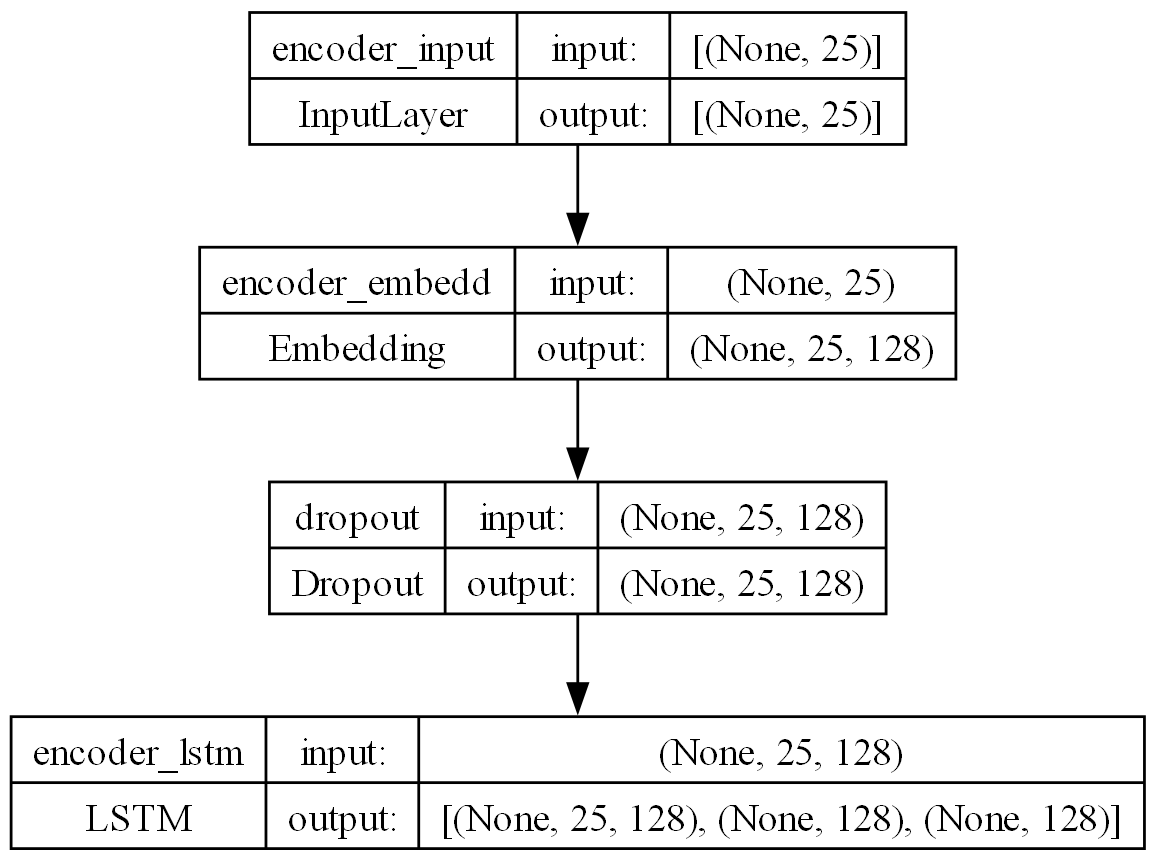

In [82]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, dpi= 200)

## Decoder

In [67]:
# 디코더 상태 입력 정의
decoder_state_input_h = Input(shape=(lstm_units,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(lstm_units,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 이전 타임 스텝의 출력을 위한 입력 정의
decoder_song_input = Input(shape=(None,), name='song_input')

# 디코더 임베딩 레이어 정의
dec_song_emb = Embedding(input_dim=song_vocab, output_dim=embed_output_dim, name='decoder_embedd')(decoder_song_input)

# 디코더 LSTM 레이어 정의
decoder_lstm_layer = LSTM(lstm_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, state_h, state_c = decoder_lstm_layer(dec_song_emb, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# 인코더의 전체 출력을 받는 입력 정의
encoder_outputs_input = Input(shape=(max_playlist_title_length, lstm_units), name='encoder_outputs_input')

# 디코더 어텐션 레이어 적용
attention_layer = Attention(name='attention_layer')
decoder_attention_output = attention_layer([decoder_outputs, encoder_outputs_input])

# 디코더 최종 출력 레이어 정의
decoder_dense = Dense(song_vocab, activation='softmax', name='song_output')
decoder_song_output = decoder_dense(decoder_attention_output)

# 디코더 모델 정의
decoder_model = Model(
    [decoder_song_input, decoder_state_input_h, decoder_state_input_c, encoder_outputs_input],
    [decoder_song_output] + decoder_states
)

# 디코더 모델 요약
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 song_input (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 decoder_embedd (Embedding)  (None, None, 128)            3343718   ['song_input[0][0]']          
                                                          4                                       
                                                                                                  
 decoder_state_input_h (Inp  [(None, 128)]                0         []                            
 utLayer)                                                                                         
                                                                                            

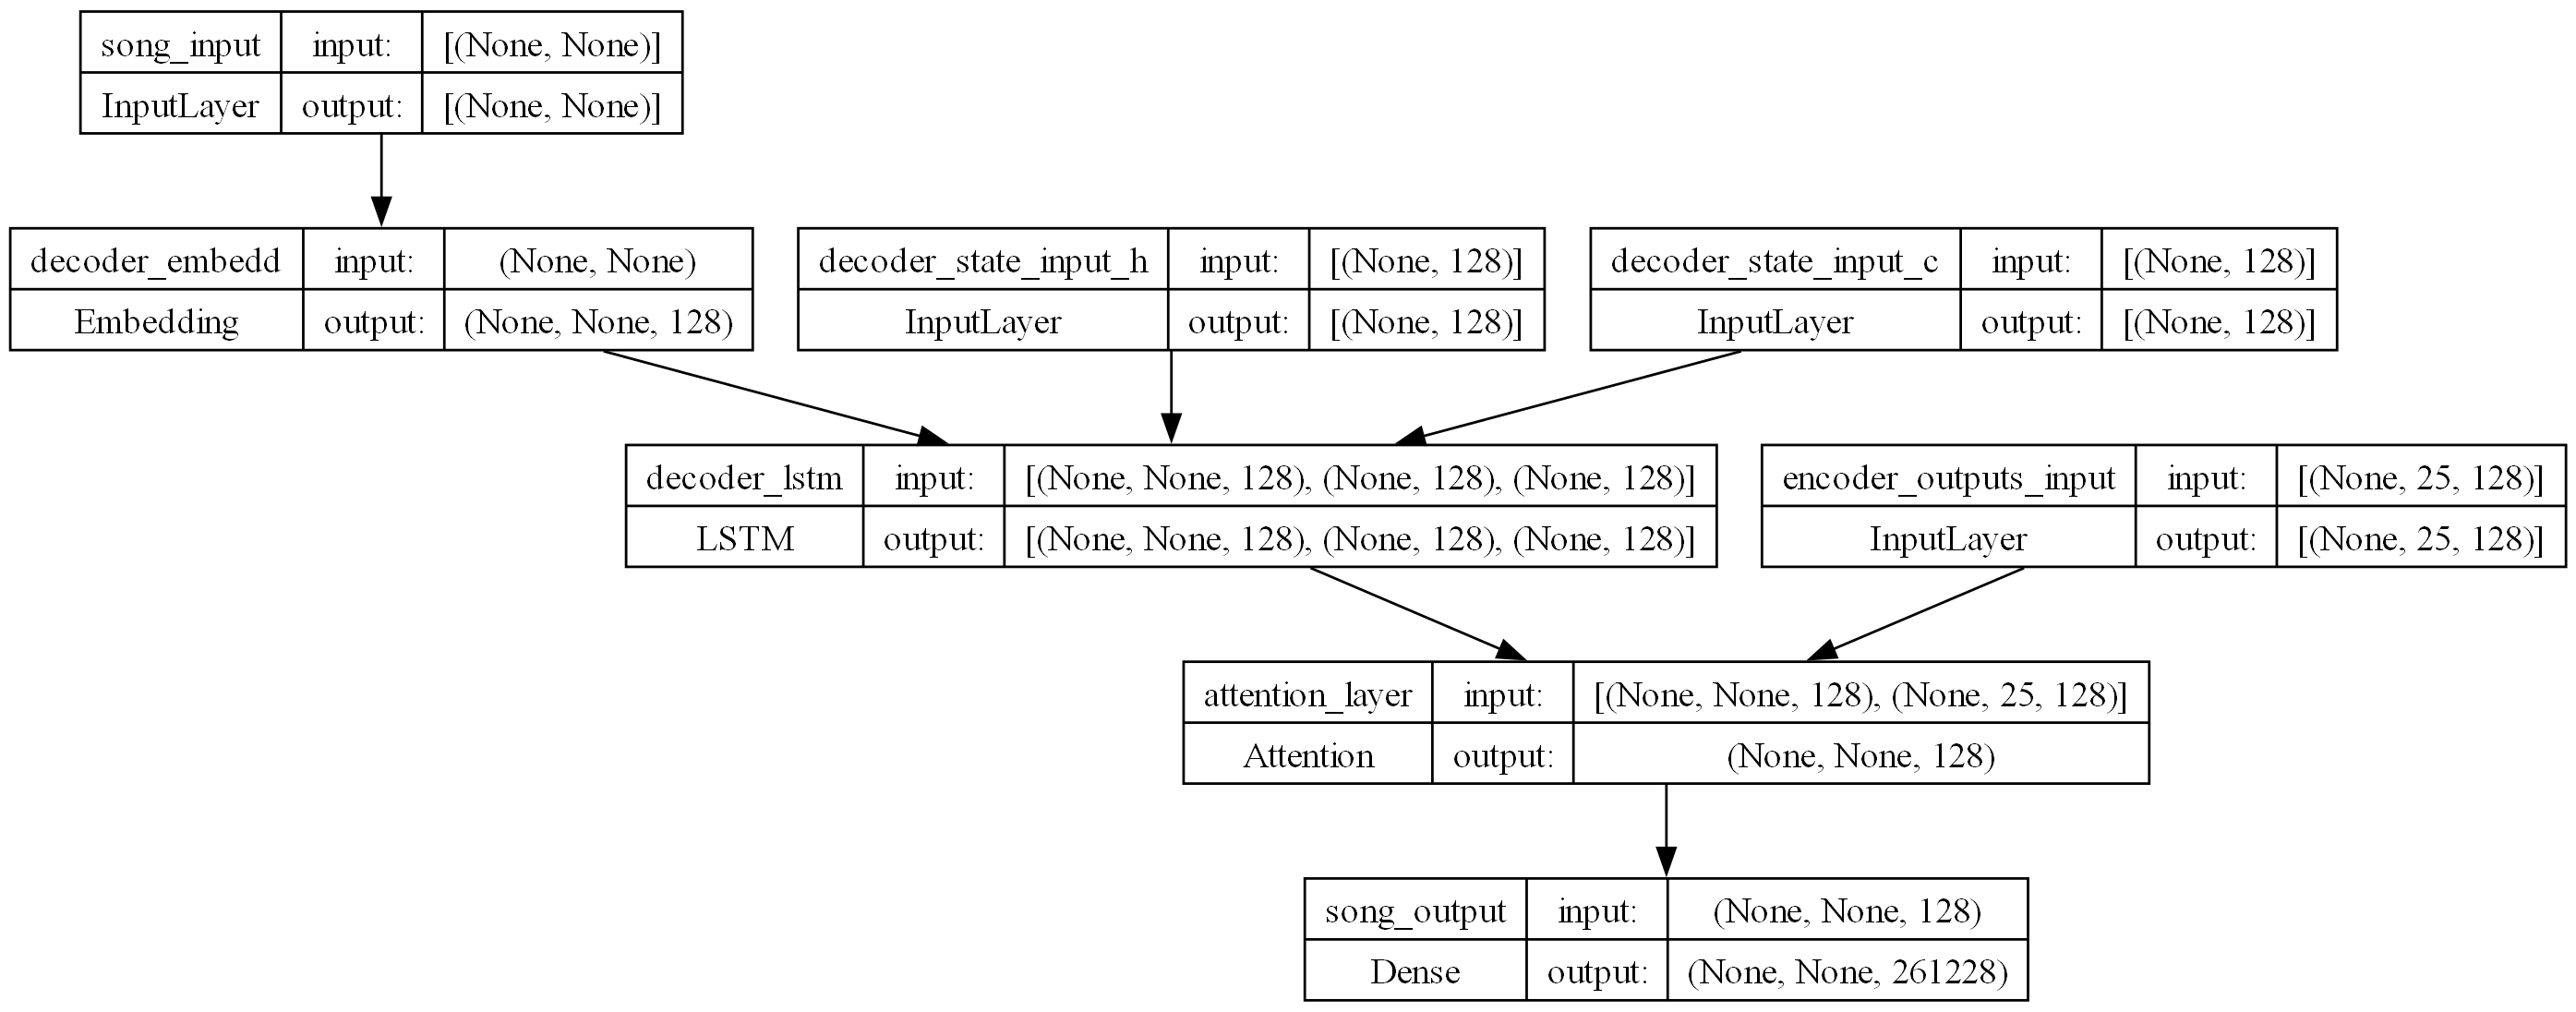

In [68]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, dpi= 200)

In [69]:
# 인코더 모델에 가중치 로드
encoder_model.load_weights('best_model_150.h5', by_name=True)

# 디코더 모델에 가중치 로드
decoder_model.load_weights('best_model_150.h5', by_name=True)

# 인코더 및 디코더 모델 저장
encoder_model.save('multi_encoder_model_200.h5')
decoder_model.save('multi_decoder_model_200.h5')

In [70]:
start_token_id = 0
stop_token_id = 1

def decode_sequence(input_seq):
    # 인코더 모델을 사용하여 전체 출력과 상태 얻기
    encoder_output, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    # 초기 입력 시퀀스 생성 (SOS 토큰)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_id

    # 예측을 위한 루프
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, state_h, state_c, encoder_output])

        # 예측된 토큰 ID 가져오기
        sampled_token_id = np.argmax(output_tokens[0, -1, :])
        if sampled_token_id != stop_token_id:
            decoded_sentence.append(sampled_token_id)

        # 종료 조건 검사
        if sampled_token_id == stop_token_id or len(decoded_sentence) >= max_songs:
            stop_condition = True

        # 시퀀스와 상태 업데이트
        target_seq[0, 0] = sampled_token_id
        state_h, state_c = h, c

    return decoded_sentence

In [77]:
# 더미 입력 시퀀스 생성
num_samples = 1
input_seq = np.random.randint(0, playlist_vocab, size=(num_samples, max_playlist_title_length))

# 인퍼런스 함수를 사용한 예측
predicted_song_ids = decode_sequence(input_seq)

1/1 [==============================] - 0s 20ms/step


In [78]:
len(predicted_song_ids)

10

In [79]:
predicted_song_ids

[261227,
 261227,
 261227,
 261227,
 261227,
 261227,
 261227,
 261227,
 261227,
 261227]